In [1]:
import pandas as pd
import time
from datetime import datetime
import matplotlib.pyplot as plt
import talib as ta
import seaborn as sns
#import cufflinks as cf
import mplfinance as mpf
import numpy as np

# GetData

In [2]:
data = pd.read_csv(r'/Users/oat/Desktop/data/CleanData/EU/EUHisdata_1221.csv')

In [3]:
data = data.iloc[:,:5]
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time',inplace=True)
data

,Open,High,Low,Close
Time,,,,
2012-01-02 02:00:00,1.29324,1.29381,1.29324,1.29332
2012-01-02 02:01:00,1.29326,1.29345,1.29275,1.29341
2012-01-02 02:02:00,1.29342,1.29344,1.29341,1.29343
2012-01-02 02:03:00,1.29342,1.29342,1.29335,1.29336
2012-01-02 02:04:00,1.29324,1.29347,1.29320,1.29346
...,...,...,...,...
2021-12-31 16:54:00,1.13797,1.13797,1.13774,1.13774
2021-12-31 16:55:00,1.13775,1.13781,1.13748,1.13748
2021-12-31 16:56:00,1.13749,1.13765,1.13704,1.13707


In [4]:
#plt.plot(df['Time'],df['Close'])

In [5]:
#Min,H,D
TF = '1H'
df = data.groupby(pd.Grouper(freq=TF)).agg({"Open": "first", 
                                             "High": "max", 
                                             "Low": "min", 
                                             "Close": "last"})
df.columns = ["Open", "High", "Low", "Close"]
df = df.loc['20150101':'20211221'].copy()
df.dropna(inplace=True)
df.reset_index(inplace = True)

In [6]:
df

,Time,Open,High,Low,Close
0,2015-01-01 13:00:00,1.20965,1.21041,1.20959,1.21002
1,2015-01-01 14:00:00,1.21000,1.21002,1.20983,1.21002
2,2015-01-01 17:00:00,1.21037,1.21072,1.21001,1.21016
3,2015-01-01 18:00:00,1.21016,1.21017,1.20783,1.20866
4,2015-01-01 19:00:00,1.20868,1.20888,1.20668,1.20672
...,...,...,...,...,...
43344,2021-12-21 19:00:00,1.12872,1.12892,1.12813,1.12821
43345,2021-12-21 20:00:00,1.12822,1.12940,1.12821,1.12866
43346,2021-12-21 21:00:00,1.12867,1.12870,1.12734,1.12772
43347,2021-12-21 22:00:00,1.12772,1.12781,1.12750,1.12762


# Signal

In [7]:
def Signal(data,fastk,slowk,slowd):
    data = df.copy()
    Close = data['Close']
    High = data['High']
    Open = data['Open']
    Low = data['Low']
    #Calculate Indicator
    CL = data['Close'] - data['Low'].rolling(fastk).min()
    HL = data['High'].rolling(fastk).max()-data['Low'].rolling(fastk).min()
    data['STO_k'] = 100*ta.SMA(CL,slowk)/ta.SMA(HL,slowk)
    data['STO_d'] = ta.SMA(data['STO_k'],slowd)
    data['SAR'] = ta.SAR(High, Low, acceleration=0.02, maximum=0.2)
    data.dropna(inplace = True)
    data.reset_index(inplace = True)
    data.drop(columns='index',inplace=True)
    #GetSignal
    for i in range(2,len(data)):
        if data.loc[i-1,'STO_k'] > data.loc[i-1,'STO_d'] and data.loc[i-2,'STO_k'] < data.loc[i-2,'STO_d']:
            Signal = 'Long'
            data.loc[i,'Signal'] = Signal
        elif data.loc[i-1,'STO_k'] < data.loc[i-1,'STO_d'] and data.loc[i-2,'STO_k'] > data.loc[i-2,'STO_d']:
            Signal = 'Short'
            data.loc[i,'Signal'] = Signal
    return data

In [8]:
data=Signal(df,9,3,5)

# BackTest-model No spead and commision

In [33]:
def Backtest(df,TP,SL,mode): #input startBalance,TPSL,Lotsize,Modeoutput,starttest,stoptest
    data = df.copy()
    winstack = []
    lossstack = []
    winrec = 0
    lossrec = 0
    #settingBalance
    status = 'Close'
    Balance = 3000
    lotsize = 0.01
    contractsize = 100000
    point = 5
    Tp = TP*(10**(-point))
    Sl = SL*(10**(-point))
    spread=0
    commission=0
    #OpenLong
    for i in range(1,len(data)):
        if data.loc[i,'Signal'] == 'Long' and status == 'Close':
            entry = data.loc[i,'Open']
            takeprofit = entry+Tp
            stoploss = entry-Sl
            status = 'Long'
            data.loc[i,'IN'] = 'Long'
            data.loc[i,'OUT'] = '-'
            data.loc[i,'Change(point)'] = 0
            data.loc[i,'Total_Balance'] = Balance
            data.loc[i,'TP'] = takeprofit
            data.loc[i,'SL'] = stoploss
    #CloseLong
        elif status == 'Long':
            if data.loc[i,'Low'] <= stoploss:
                data.loc[i,'IN'] = '-'
                data.loc[i,'OUT'] = 'SL'
                data.loc[i,'TP'] = 0
                data.loc[i,'SL'] = 0
                data.loc[i,'Change(point)'] = abs(entry-stoploss)
                Balance = Balance - (data.loc[i,'Change(point)']*lotsize*contractsize)
                data.loc[i,'Total_Balance'] = Balance
                if winrec > 1:
                    winstack.append(winrec)
                winrec = 0
                lossrec += 1
                status = 'Close'
            elif status == 'Long' and data.loc[i,'High'] >= takeprofit:
                data.loc[i,'IN'] = '-'
                data.loc[i,'OUT'] = 'TP'
                data.loc[i,'TP'] = 0
                data.loc[i,'SL'] = 0
                data.loc[i,'Change(point)'] = abs(entry-takeprofit)
                Balance = Balance + (data.loc[i,'Change(point)']*lotsize*contractsize)
                data.loc[i,'Total_Balance'] = Balance
                if lossrec > 1:
                    lossstack.append(lossrec)
                    #data.loc[i,'Lossaccum'] = lossrec
                winrec += 1
                lossrec = 0
                status = 'Close'
        #OpenShort
        elif data.loc[i,'Signal'] == 'Short' and status == 'Close':
            entry = data.loc[i,'Open']
            takeprofit = entry-Tp
            stoploss = entry+Sl
            data.loc[i,'TP'] = takeprofit
            data.loc[i,'SL'] = stoploss
            data.loc[i,'IN'] = 'Short'
            data.loc[i,'OUT'] = '-'
            data.loc[i,'Change(point)'] = 0
            data.loc[i,'Total_Balance'] = Balance
            status = 'Short'
        #Close_Short
        elif status == 'Short':
            if data.loc[i,'High'] <= stoploss:
                status = 'Close'
                data.loc[i,'IN'] = '-'
                data.loc[i,'OUT'] = 'SL'
                data.loc[i,'TP'] = 0
                data.loc[i,'SL'] = 0
                data.loc[i,'Change(point)'] = abs(entry-stoploss)
                Balance = Balance - (data.loc[i,'Change(point)']*lotsize*contractsize)
                data.loc[i,'Total_Balance'] = Balance
                if winrec > 1:
                    winstack.append(winrec)
                winrec = 0
                lossrec += 1
            elif data.loc[i,'Low'] >= takeprofit:
                status = 'Close'
                data.loc[i,'IN'] = '-'
                data.loc[i,'OUT'] = 'TP'
                data.loc[i,'TP'] = 0
                data.loc[i,'SL'] = 0
                data.loc[i,'Change(point)'] = abs(entry-takeprofit)
                Balance = Balance + (data.loc[i,'Change(point)']*lotsize*contractsize)
                data.loc[i,'Total_Balance'] = Balance
                if lossrec > 1:
                    lossstack.append(lossrec)
                winrec += 1
                lossrec = 0
    deal = data.dropna()
    deal.reset_index(inplace=True)
    deal.drop(columns='index',inplace=True)
    if mode == 1:
        return data
    elif mode == 2:
        print('Balance : ',Balance)
        #print('ProfitFactor : ')
        print('Total Trade : ',sum(winstack)+sum(lossstack))
        print('WinRate : ',"{:.2%}".format(sum(winstack)/(sum(winstack)+sum(lossstack))))
        print('Maximal consecutive wins : ',max(winstack),'|','consecutive loss : ',max(lossstack))
        print('Average consecutive wins : ',"{:.2f}".format(np.array(winstack).mean()),'|','consecutive loss : ',"{:.2f}".format(np.array(lossstack).mean()))
        Rt = deal.iloc[:,:5].copy()
        Rt['Balance'] = deal['Total_Balance']
        Rt['Close_diff'] = Rt['Close']/Rt['Close'][0]-1
        Rt['Balance_diff'] = Rt['Balance']/Rt['Balance'][0]-1
        Rt.set_index('Time',inplace=True)
        cols=['Close_diff','Balance_diff']
        Rt[cols].plot(figsize=(15,4))
        return deal

Balance :  1749.0
Total Trade :  5189
WinRate :  34.80%
Maximal consecutive wins :  9 | consecutive loss :  15
Average consecutive wins :  2.66 | consecutive loss :  3.36


/var/folders/v8/3_1kfp_s0k1bj7k2crs_p8gh0000gn/T/ipykernel_5803/3086346457.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deal.drop(columns='index',inplace=True)


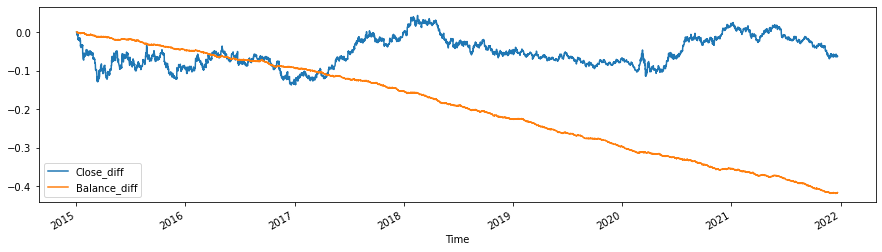

In [34]:
Deal = Backtest(data,100,100,2)

In [117]:
def Backtest2(df,TP,SL,mode): #input startBalance,TPSL,Lotsize,Modeoutput,starttest,stoptest
    data = df.copy()
    winstack = []
    lossstack = []
    winrec = 0
    lossrec = 0
    #settingBalance
    status = 'Close'
    Balance = 3000
    lotsize = 0.01
    contractsize = 100000
    point = 5
    Tp = TP*(10**(-point))
    Sl = SL*(10**(-point))
    spread=0
    commission= 7*0.01
    #OpenLong
    for i in range(1,len(data)):
        if data.loc[i,'Signal'] == 'Long' and status == 'Close':
            entry = data.loc[i,'Open'] + spread
            takeprofit = entry+Tp
            stoploss = entry-Sl
            status = 'Long'
            data.loc[i,'IN'] = 'Long'
            data.loc[i,'OUT'] = '-'
            data.loc[i,'Change(point)'] = 0
            data.loc[i,'Total_Balance'] = Balance
            data.loc[i,'TP'] = takeprofit
            data.loc[i,'SL'] = stoploss
    #CloseLong
        elif status == 'Long':
            if data.loc[i,'Low'] <= stoploss:
                data.loc[i,'IN'] = '-'
                data.loc[i,'OUT'] = 'SL'
                data.loc[i,'TP'] = 0
                data.loc[i,'SL'] = 0
                data.loc[i,'Change(point)'] = abs(entry-stoploss)
                Balance = Balance - (data.loc[i,'Change(point)']*lotsize*contractsize)-commission
                data.loc[i,'Total_Balance'] = Balance
                if winrec > 1:
                    winstack.append(winrec)
                winrec = 0
                lossrec += 1
                data.loc[i,'Signal'] = 'Close'
                status = 'Close'
            elif status == 'Long' and data.loc[i,'High'] >= takeprofit:
                data.loc[i,'IN'] = '-'
                data.loc[i,'OUT'] = 'TP'
                data.loc[i,'TP'] = 0
                data.loc[i,'SL'] = 0
                data.loc[i,'Change(point)'] = abs(entry-takeprofit)
                Balance = Balance + (data.loc[i,'Change(point)']*lotsize*contractsize)-commission
                data.loc[i,'Total_Balance'] = Balance
                if lossrec > 1:
                    lossstack.append(lossrec)
                    #data.loc[i,'Lossaccum'] = lossrec
                winrec += 1
                lossrec = 0
                data.loc[i,'Signal'] = 'Close'
                status = 'Close'
        #OpenShort
        elif data.loc[i,'Signal'] == 'Short' and status == 'Close':
            entry = data.loc[i,'Open']-spread
            takeprofit = entry-Tp
            stoploss = entry+Sl
            data.loc[i,'TP'] = takeprofit
            data.loc[i,'SL'] = stoploss
            data.loc[i,'IN'] = 'Short'
            data.loc[i,'OUT'] = '-'
            data.loc[i,'Change(point)'] = 0
            data.loc[i,'Total_Balance'] = Balance
            status = 'Short'
        #Close_Short
        elif status == 'Short':
            if data.loc[i,'High'] <= stoploss:
                status = 'Close'
                data.loc[i,'IN'] = '-'
                data.loc[i,'OUT'] = 'SL'
                data.loc[i,'TP'] = 0
                data.loc[i,'SL'] = 0
                data.loc[i,'Signal'] = 'Close'
                data.loc[i,'Change(point)'] = abs(entry-stoploss)
                Balance = Balance - (data.loc[i,'Change(point)']*lotsize*contractsize)-commission
                data.loc[i,'Total_Balance'] = Balance
                if winrec > 1:
                    winstack.append(winrec)
                winrec = 0
                lossrec += 1
            elif data.loc[i,'Low'] >= takeprofit:
                status = 'Close'
                data.loc[i,'IN'] = '-'
                data.loc[i,'OUT'] = 'TP'
                data.loc[i,'TP'] = 0
                data.loc[i,'SL'] = 0
                data.loc[i,'Change(point)'] = abs(entry-takeprofit)
                Balance = Balance + (data.loc[i,'Change(point)']*lotsize*contractsize)-commission
                data.loc[i,'Total_Balance'] = Balance
                if lossrec > 1:
                    lossstack.append(lossrec)
                winrec += 1
                lossrec = 0
                data.loc[i,'Signal'] = 'Close'
    deal = data.dropna()
    deal['HighValue'] = deal['Total_Balance'].cummax()
    deal['Drawdown'] = (deal['Total_Balance'] - deal['HighValue'])/deal['HighValue']
    deal.reset_index(inplace=True)
    deal.drop(columns='index',inplace=True)
    if mode == 1:
        return data
    elif mode == 2:
        print('Balance : ','{:.2f}'.format(Balance))
        #print('ProfitFactor : ')
        print('Total Trade : ',sum(winstack)+sum(lossstack))
        print('Maximum DrawDrown : ',"{:.2%}".format(abs(deal['Drawdown'].min())))
        print('WinRate : ',"{:.2%}".format(sum(winstack)/(sum(winstack)+sum(lossstack))))
        print('Maximal consecutive wins : ',max(winstack),'|','consecutive loss : ',max(lossstack))
        print('Average consecutive wins : ',"{:.2f}".format(np.array(winstack).mean()),'|','consecutive loss : ',"{:.2f}".format(np.array(lossstack).mean()))
        Rt = deal.iloc[:,:5].copy()
        Rt['Balance'] = deal['Total_Balance']
        Rt['Close_diff'] = Rt['Close']/Rt['Close'][0]-1
        Rt['Balance_diff'] = Rt['Balance']/Rt['Balance'][0]-1
        Rt.set_index('Time',inplace=True)
        cols=['Close_diff','Balance_diff']
        Rt[cols].plot(figsize=(15,4))
        return deal

/var/folders/v8/3_1kfp_s0k1bj7k2crs_p8gh0000gn/T/ipykernel_5803/3197517557.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deal['HighValue'] = deal['Total_Balance'].cummax()
/var/folders/v8/3_1kfp_s0k1bj7k2crs_p8gh0000gn/T/ipykernel_5803/3197517557.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deal['Drawdown'] = (deal['Total_Balance'] - deal['HighValue'])/deal['HighValue']
/var/folders/v8/3_1kfp_s0k1bj7k2crs_p8gh0000gn/T/ipykernel_5803/3197517557.py:107: SettingWithCopyWarning: 
A value is try

Balance :  1251.79
Total Trade :  5189
Maximum DrawDrown :  58.44%
WinRate :  34.80%
Maximal consecutive wins :  9 | consecutive loss :  15
Average consecutive wins :  2.66 | consecutive loss :  3.36


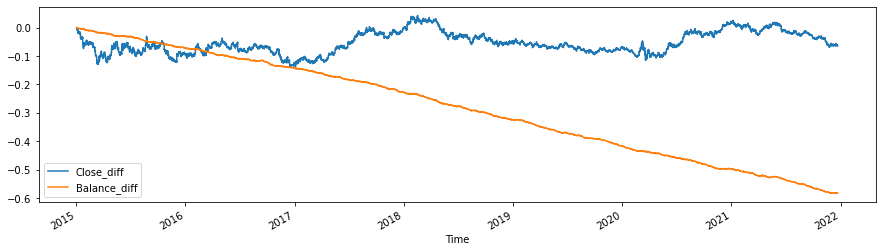

In [118]:
Deal = Backtest2(data,100,100,2)

In [119]:
Deal

,Time,Open,High,Low,Close,STO_k,STO_d,SAR,Signal,TP,SL,IN,OUT,Change(point),Total_Balance,HighValue,Drawdown
0,2015-01-02 08:00:00,1.20382,1.20442,1.20254,1.20310,24.558304,38.433539,1.205861,Short,1.20282,1.20482,Short,-,0.000,3000.00,3000.0,0.000000
1,2015-01-02 09:00:00,1.20310,1.20335,1.20085,1.20149,10.801144,33.448186,1.205490,Close,0.00000,0.00000,-,SL,0.001,2998.93,3000.0,-0.000357
2,2015-01-02 13:00:00,1.20098,1.20155,1.20080,1.20120,11.642651,16.375451,1.203200,Long,1.20198,1.19998,Long,-,0.000,2998.93,3000.0,-0.000357
3,2015-01-04 17:00:00,1.19427,1.19539,1.18664,1.19451,30.725624,12.423128,1.201425,Close,0.00000,0.00000,-,SL,0.001,2997.86,3000.0,-0.000713
4,2015-01-04 18:00:00,1.19453,1.19494,1.19301,1.19468,42.398514,18.574301,1.200600,Long,1.19553,1.19353,Long,-,0.000,2997.86,3000.0,-0.000713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14201,2021-12-21 08:00:00,1.12941,1.13014,1.12883,1.12906,53.058677,62.764659,1.130154,Close,0.00000,0.00000,-,TP,0.001,1251.93,3000.0,-0.582690
14202,2021-12-21 14:00:00,1.12734,1.12818,1.12725,1.12811,31.954582,20.807643,1.129050,Long,1.12834,1.12634,Long,-,0.000,1251.93,3000.0,-0.582690
14203,2021-12-21 16:00:00,1.12825,1.12878,1.12787,1.12823,52.170352,33.503439,1.126070,Close,0.00000,0.00000,-,TP,0.001,1252.86,3000.0,-0.582380
14204,2021-12-21 22:00:00,1.12772,1.12781,1.12750,1.12762,48.592411,68.938034,1.126694,Short,1.12672,1.12872,Short,-,0.000,1252.86,3000.0,-0.582380
